# Spectral Analysis using xrft and Pangeo


**Contents**

* Load data from LLC4320
* Fields
* Power Spectra
* Cross Spectra
* Rotary Spectra
* Spectral transfer rates

In [1]:
# Set to have less messages from distributed
import dask
dask.config.set({"logging.distributed": "error"})

In [2]:
# Setup cluster
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20)
client = Client(cluster)
client

<Client: 'tcp://10.32.10.8:42981' processes=0 threads=0, memory=0 B>

In [3]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [4]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [5]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [10]:
ds = xr.merge([ssh, sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

In [11]:
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

### Data from the region 

In [12]:
# pick a region that is not too close to the poles, here the grid 
# is approximately squarish
sel_area = np.logical_and(np.logical_and(coords.XC>25, coords.XC<45 ),
                           np.logical_and(coords.YC>-55, coords.YC<-49 ))

In [13]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [14]:
X = coords.XC.where(sel_area, drop=True)
Y = coords.YC.where(sel_area, drop=True)
Xmean = X.mean(['j'])
Ymean = Y.mean(['i'])

In [15]:
SSH_sel = ds.Eta.where(sel_area, drop=True)
SST_sel = ds.SST.where(sel_area, drop=True)

In [18]:
SST_sel.data

dask.array<where, shape=(9030, 494, 960), dtype=float32, chunksize=(1, 494, 960), chunktype=numpy.ndarray>

In [19]:
SSS_sel = ds.SSS.where(sel_area, drop=True)

In [20]:
U_sel = (grid.interp(ds.U, 'X', boundary='extend')).where(sel_area, drop=True).rename('U')
V_sel = (grid.interp(ds.V, 'Y', boundary='extend')).where(sel_area, drop=True).rename('V')

In [21]:
from fastjmd95 import rho
SSD_sel = xr.apply_ufunc(rho, 
                        SSS_sel, SST_sel, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

In [22]:
ds_sel = xr.merge([SSH_sel, SST_sel, SSS_sel, U_sel, V_sel, SSD_sel]
                 ).assign_coords(XC=Xmean, YC=Ymean)

In [18]:
ds_sel_loaded =  ds_sel.isel(time=0)
ds_sel_loaded.load();

<xarray.Dataset>
Dimensions:  (i: 960, j: 494)
Coordinates:
    time     datetime64[ns] 2011-09-13
  * i        (i) int64 3024 3025 3026 3027 3028 ... 3979 3980 3981 3982 3983
  * j        (j) int64 4499 4500 4501 4502 4503 ... 4988 4989 4990 4991 4992
    XC       (i) float32 25.010483 25.03125 25.052017 ... 44.96875 44.98966
    YC       (j) float32 -54.99077 -54.979313 ... -49.020023 -49.007187
Data variables:
    Eta      (j, i) float32 -0.9827885 -0.98390853 ... -0.62796766 -0.6267822
    SST      (j, i) float32 -0.78739285 -0.8285764 ... 3.5014613 3.530045
    SSS      (j, i) float32 33.945534 33.945717 33.94485 ... 33.968674 33.971104
    U        (j, i) float32 0.26562348 0.2811809 ... -0.0630344 -0.07035835
    V        (j, i) float32 0.037328035 0.047492266 ... -0.11144471 -0.12167652
    SSD      (j, i) float64 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03

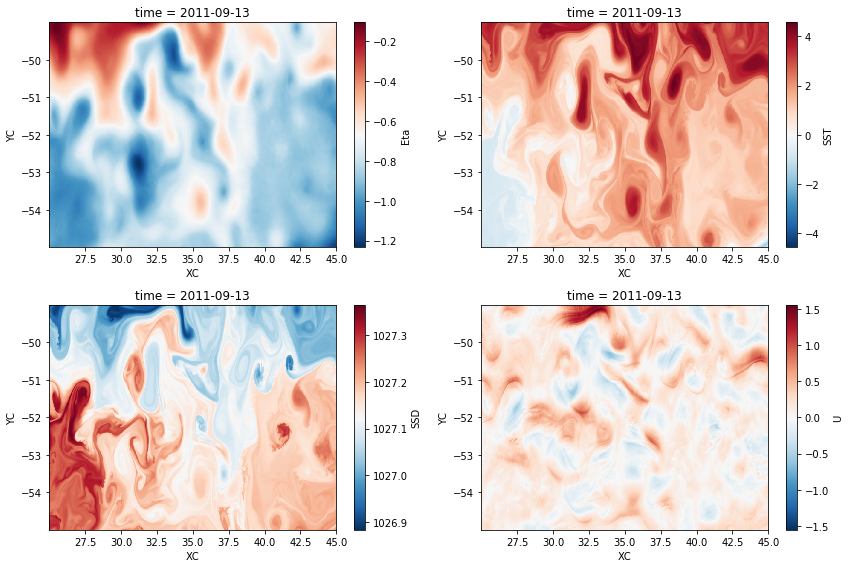

In [19]:
plt.figure(figsize=(12,8))

plt.subplot(221)
ds_sel_loaded.Eta.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(222)
ds_sel_loaded.SST.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(223)
ds_sel_loaded.SSD.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(224)
ds_sel_loaded.U.plot(x='XC', y='YC', cmap='RdBu_r')

plt.tight_layout()

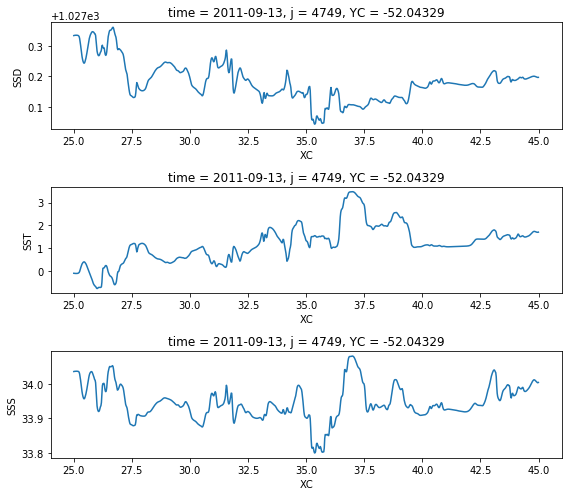

In [20]:
plt.figure(figsize=(8,7))
plt.subplot(311)
ds_sel_loaded.SSD.isel(j=250).plot(x='XC' )

plt.subplot(312)
ds_sel_loaded.SST.isel(j=250).plot(x='XC' )

plt.subplot(313)
ds_sel_loaded.SSS.isel(j=250).plot(x='XC' )

plt.tight_layout()

## Power Spectra

### Wavenumber Spectra

In [49]:
SSH_k_ps = xrft.power_spectrum(ds_sel_loaded.Eta, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
SST_k_ps = xrft.power_spectrum(ds_sel_loaded.SST, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
SSD_k_ps = xrft.power_spectrum(ds_sel_loaded.SSD, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
U_k_ps = xrft.power_spectrum(ds_sel_loaded.U, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
V_k_ps = xrft.power_spectrum(ds_sel_loaded.V, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')

In [54]:
ds_sel_loaded_k_ps = xr.merge([SSH_k_ps.rename('SSH_ps'),
                               SST_k_ps.rename('SST_ps'), 
                               SSD_k_ps.rename('SSD_ps'),
                               U_k_ps.rename('U_ps'),
                               V_k_ps.rename('V_ps')])

In [55]:
ds_sel_loaded_k_ps.load()

<xarray.Dataset>
Dimensions:         (freq_i: 960, j: 494)
Coordinates:
  * j               (j) int64 4499 4500 4501 4502 4503 ... 4989 4990 4991 4992
  * freq_i          (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499
    freq_i_spacing  float64 0.001042
Data variables:
    SSH_ps          (j, freq_i) float64 2.889e-11 5.789e-11 ... 3.552e-10
    SST_ps          (j, freq_i) float64 4.784e-06 5.128e-06 ... 2.18e-06
    SSD_ps          (freq_i, j) float64 4.995e-09 1.696e-08 ... 2.87e-08
    U_ps            (j, freq_i) float64 1.447e-12 6.506e-12 ... 1.119e-11
    V_ps            (j, freq_i) float64 7.919e-08 5.444e-08 ... 3.288e-07

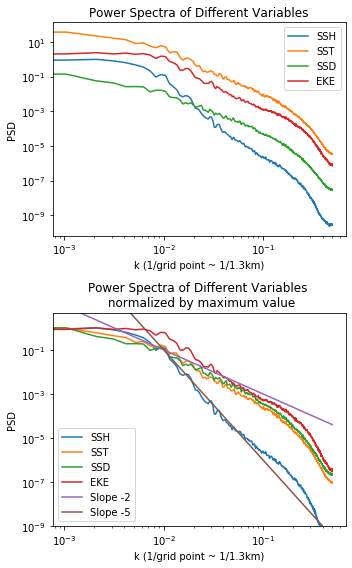

In [77]:
plt.figure(figsize=(5,8))

plt.subplot(211)
(ds_sel_loaded_k_ps.SSH_ps.mean('j')/ds_sel_loaded_k_ps.SSH_ps.mean('j').max()
        ).plot(label='SSH')
ds_sel_loaded_k_ps.SST_ps.mean('j').plot(label='SST')
ds_sel_loaded_k_ps.SSD_ps.mean('j').plot(label='SSD')
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').plot(label='EKE')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.legend()
plt.title('Power Spectra of Different Variables')

plt.subplot(212)
(ds_sel_loaded_k_ps.SSH_ps.mean('j')/ds_sel_loaded_k_ps.SSH_ps.mean('j').max()
        ).plot(label='SSH')
(ds_sel_loaded_k_ps.SST_ps.mean('j')/ds_sel_loaded_k_ps.SST_ps.mean('j').max()
        ).plot(label='SST')
(ds_sel_loaded_k_ps.SSD_ps.mean('j')/ds_sel_loaded_k_ps.SSD_ps.mean('j').max()
        ).plot(label='SSD')
((ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j')/
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').max()
    ).plot(label='EKE')

plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-5*ds_sel_loaded_k_ps.freq_i**-2, label='Slope -2')
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-11*ds_sel_loaded_k_ps.freq_i**-5, label='Slope -5')
plt.ylim([1e-9, 5])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.title('Power Spectra of Different Variables \n normalized by maximum value')
plt.legend()
plt.tight_layout()


### Frequency Spectra

In [27]:
SSH_sel.data

dask.array<where, shape=(9030, 494, 960), dtype=float32, chunksize=(1, 494, 960), chunktype=numpy.ndarray>

In [23]:
# Take a smaller subset of the data for the frequency spectra
subset_factor = 30

SSH_sel_subset = (SSH_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,30*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 360, 'point':100}))

V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,30*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 360, 'point':100}))

In [25]:
SSH_sel_subset.data

dask.array<rechunk-merge, shape=(720, 544), dtype=float32, chunksize=(360, 100), chunktype=numpy.ndarray>

In [24]:
SSH_ps_t = xrft.power_spectrum(SSH_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [26]:
SSH_ps_t.data

dask.array<truediv, shape=(2, 360, 544), dtype=float64, chunksize=(1, 360, 100), chunktype=numpy.ndarray>

In [20]:
V_ps_t = xrft.power_spectrum(V_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [21]:
SSH_ps_t_av = SSH_ps_t.mean(dim=['time_segment', 'point'])
V_ps_t_av = V_ps_t.mean(dim=['time_segment', 'point'])

In [22]:
SSH_ps_t_av_p = SSH_ps_t_av.persist(retries=10)

In [23]:
V_ps_t_av_p = V_ps_t_av.persist(retries=10)

In [27]:
SSH_ps_t_av_p

<xarray.DataArray 'rechunk-merge-8328c755ae9109ec53f71465013ce3f1' (freq_time: 360)>
dask.array<mean_agg-aggregate, shape=(360,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001381 ... 0.0001381
    freq_time_spacing  float64 7.716e-07

In [26]:
SSH_ps_t_av_p.load()

KilledWorker: ("('concatenate-zarr-getitem-7388507b7cc7ce73c4d7f5575c4a53ba', 690, 0, 0)", <Worker 'tcp://10.32.57.4:35047', memory: 0, processing: 3>)

In [ ]:
V_ps_t_av_p.load()

#### Some density maps 

In [21]:
SSD_4times = ds_sel.SSD.isel(time=slice(0,360*24,90*24))

In [27]:
SSD_12times = ds_sel.SSD.isel(time=slice(0,360*24,30*24))

In [34]:
SSD_12times.load()

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-42d332bc5f8d5ab47ee824a1feb4b895', 2, 0, 0)": [], "('getitem-42d332bc5f8d5ab47ee824a1feb4b895', 4, 0, 0)": []} state: ['waiting', 'waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-42d332bc5f8d5ab47ee824a1feb4b895', 2, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-42d332bc5f8d5ab47ee824a1feb4b895', 4, 0, 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('getitem-42d332bc5f8d5ab47ee824a1feb4b895', 2, 0, 0)": (), "('getitem-42d332bc5f8d5ab47ee824a1feb4b895', 4, 0, 0)": ()}


<xarray.DataArray 'SSD' (time: 12, j: 494, i: 960)>
array([[[1027.29059617, 1027.29237085, 1027.29380341, ...,
         1027.22048824, 1027.21914062, 1027.21542867],
        [1027.289734  , 1027.29021964, 1027.29163388, ...,
         1027.21991487, 1027.21970567, 1027.217422  ],
        [1027.29044605, 1027.29048741, 1027.29057936, ...,
         1027.22029501, 1027.2201135 , 1027.21897146],
        ...,
        [1026.94285492, 1026.94068638, 1026.93917476, ...,
         1027.01604256, 1027.01589906, 1027.01539819],
        [1026.93966572, 1026.93766105, 1026.93663072, ...,
         1027.01579319, 1027.01556951, 1027.01493229],
        [1026.93718586, 1026.93614662, 1026.93606078, ...,
         1027.01560836, 1027.01524678, 1027.01443235]],

       [[1027.30956208, 1027.30318132, 1027.29869135, ...,
         1027.24294794, 1027.24336626, 1027.24291723],
        [1027.3030059 , 1027.29900469, 1027.29881814, ...,
         1027.24335361, 1027.24329806, 1027.2419665 ],
        [1027.29948761, 1027.29953098, 1027.30227911, ...,
         1027.24345704, 1027.24293973, 1027.2409963 ],
        ...,
        [1026.98064739, 1026.97898564, 1026.97800741, ...,
         1027.03703673, 1027.03833595, 1027.03970738],
        [1026.97906689, 1026.9782542 , 1026.97796232, ...,
         1027.04094975, 1027.04243518, 1027.04383859],
        [1026.97779786, 1026.97801669, 1026.97884785, ...,
         1027.04425478, 1027.04547865, 1027.04631172]],

       [[1027.33476291, 1027.3562994 , 1027.37008684, ...,
         1027.19801096, 1027.20011426, 1027.20407913],
        [1027.33846166, 1027.35984065, 1027.3698488 , ...,
         1027.19664665, 1027.20056999, 1027.20435223],
        [1027.34277155, 1027.36291798, 1027.36843427, ...,
         1027.19677562, 1027.20188763, 1027.20458018],
        ...,
        [1026.95543945, 1026.95015619, 1026.94507415, ...,
         1027.01900789, 1027.01535661, 1027.01219516],
        [1026.94927712, 1026.94478114, 1026.94468583, ...,
         1027.01736388, 1027.01387738, 1027.01112631],
        [1026.94493345, 1026.94449959, 1026.94467291, ...,
         1027.01554064, 1027.01244839, 1027.01018343]],

       ...,

       [[1027.28264056, 1027.28379831, 1027.28932336, ...,
         1027.10501422, 1027.10440245, 1027.10379085],
        [1027.28700007, 1027.28705666, 1027.29020566, ...,
         1027.10359792, 1027.1030062 , 1027.10262406],
        [1027.29028963, 1027.29229057, 1027.29526536, ...,
         1027.10180947, 1027.10164332, 1027.10178813],
        ...,
        [1026.92998716, 1026.93063702, 1026.93048716, ...,
         1026.84052762, 1026.83780609, 1026.83427353],
        [1026.93082754, 1026.92876092, 1026.92524431, ...,
         1026.83991508, 1026.83964303, 1026.83808634],
        [1026.92704934, 1026.92432069, 1026.92223066, ...,
         1026.83763811, 1026.83659417, 1026.83885218]],

       [[1027.32455919, 1027.32534106, 1027.32726975, ...,
         1027.21683613, 1027.21444338, 1027.21256668],
        [1027.32238785, 1027.32112646, 1027.3204123 , ...,
         1027.21241451, 1027.2111585 , 1027.20911803],
        [1027.32281016, 1027.32157937, 1027.32027831, ...,
         1027.20837839, 1027.20638206, 1027.20358354],
        ...,
        [1026.99112897, 1026.98920903, 1026.98751334, ...,
         1026.9273198 , 1026.92861888, 1026.92902196],
        [1026.9924997 , 1026.9905647 , 1026.9887465 , ...,
         1026.92513626, 1026.92724163, 1026.92877949],
        [1026.99386202, 1026.99202659, 1026.99016752, ...,
         1026.92061203, 1026.92314417, 1026.92538858]],

       [[1027.35038777, 1027.33326287, 1027.33062054, ...,
         1027.23097782, 1027.23249057, 1027.23149654],
        [1027.35061435, 1027.33573153, 1027.3309853 , ...,
         1027.2284849 , 1027.22981575, 1027.22967205],
        [1027.36416921, 1027.34200253, 1027.3510863 , ...,
         1027.22692921, 1027.22857433, 1027.22766538],
        ...,
        [1027.07379534, 1027.07686503, 1027.07546054, ...,
         1027.00294521, 10

In [22]:
SSD_4times.load()

<xarray.DataArray 'SSD' (time: 4, j: 494, i: 960)>
array([[[1027.29059617, 1027.29237085, 1027.29380341, ...,
         1027.22048824, 1027.21914062, 1027.21542867],
        [1027.289734  , 1027.29021964, 1027.29163388, ...,
         1027.21991487, 1027.21970567, 1027.217422  ],
        [1027.29044605, 1027.29048741, 1027.29057936, ...,
         1027.22029501, 1027.2201135 , 1027.21897146],
        ...,
        [1026.94285492, 1026.94068638, 1026.93917476, ...,
         1027.01604256, 1027.01589906, 1027.01539819],
        [1026.93966572, 1026.93766105, 1026.93663072, ...,
         1027.01579319, 1027.01556951, 1027.01493229],
        [1026.93718586, 1026.93614662, 1026.93606078, ...,
         1027.01560836, 1027.01524678, 1027.01443235]],

       [[1027.24777996, 1027.24469434, 1027.24375244, ...,
         1027.19034906, 1027.19165669, 1027.19221846],
        [1027.24761672, 1027.24468964, 1027.24390694, ...,
         1027.18537286, 1027.18788483, 1027.18939124],
        [1027.24758925, 1027.24463857, 1027.24406378, ...,
         1027.18005278, 1027.18266586, 1027.18476002],
        ...,
        [1026.91940538, 1026.91760815, 1026.91587924, ...,
         1026.90204173, 1026.90169727, 1026.90109705],
        [1026.91385659, 1026.91352586, 1026.91305537, ...,
         1026.89987536, 1026.89949132, 1026.89900368],
        [1026.91190282, 1026.91033421, 1026.90938676, ...,
         1026.89840675, 1026.89850099, 1026.89860672]],

       [[1027.05280562, 1027.0621459 , 1027.06655904, ...,
         1027.02865035, 1027.02672357, 1027.02513354],
        [1027.04336843, 1027.05067005, 1027.06005254, ...,
         1027.03459201, 1027.03386349, 1027.03342399],
        [1027.04124971, 1027.04364115, 1027.04958735, ...,
         1027.03439347, 1027.03315941, 1027.03225421],
        ...,
        [1026.81805559, 1026.81127978, 1026.80609368, ...,
         1026.70362692, 1026.70697469, 1026.7097625 ],
        [1026.83138502, 1026.82938054, 1026.8265355 , ...,
         1026.70980201, 1026.7121508 , 1026.71142037],
        [1026.83119739, 1026.83208507, 1026.83223691, ...,
         1026.71394931, 1026.7141069 , 1026.7060408 ]],

       [[1027.28264056, 1027.28379831, 1027.28932336, ...,
         1027.10501422, 1027.10440245, 1027.10379085],
        [1027.28700007, 1027.28705666, 1027.29020566, ...,
         1027.10359792, 1027.1030062 , 1027.10262406],
        [1027.29028963, 1027.29229057, 1027.29526536, ...,
         1027.10180947, 1027.10164332, 1027.10178813],
        ...,
        [1026.92998716, 1026.93063702, 1026.93048716, ...,
         1026.84052762, 1026.83780609, 1026.83427353],
        [1026.93082754, 1026.92876092, 1026.92524431, ...,
         1026.83991508, 1026.83964303, 1026.83808634],
        [1026.92704934, 1026.92432069, 1026.92223066, ...,
         1026.83763811, 1026.83659417, 1026.83885218]]])
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-12-12 2012-03-11 2012-06-09
  * i        (i) int64 3024 3025 3026 3027 3028 ... 3979 3980 3981 3982 3983
  * j        (j) int64 4499 4500 4501 4502 4503 ... 4988 4989 4990 4991 4992
    XC       (i) float32 25.010483 25.03125 25.052017 ... 44.96875 44.98966
    YC       (j) float32 -54.99077 -54.979313 ... -49.020023 -49.007187

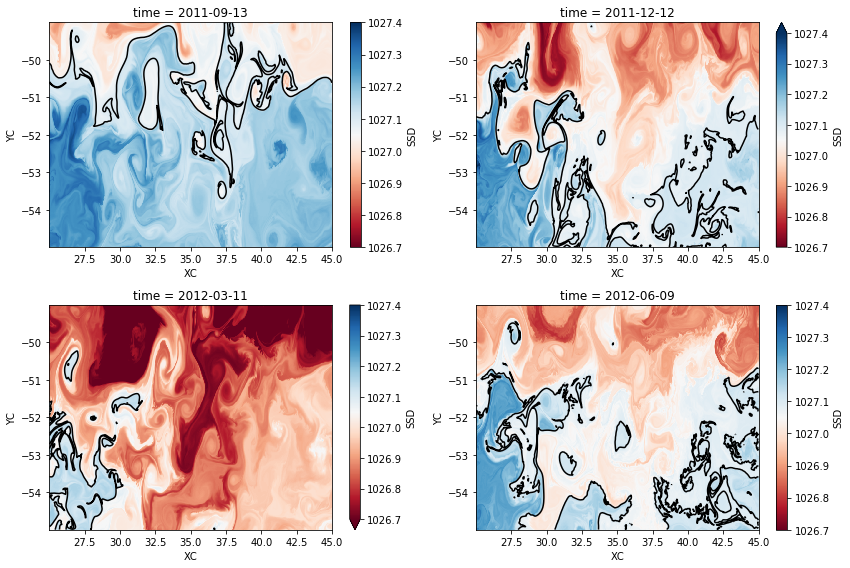

In [39]:
plt.figure(figsize=(12,8))

plt.subplot(221)
SSD_4times.isel(time=0).plot(x='XC', y='YC', cmap='RdBu'
                             , vmin=1026.7, vmax=1027.4)
SSD_4times.isel(time=0).plot.contour(x='XC', y='YC'
                             ,levels=[1027.1], colors='k')


plt.subplot(222)
SSD_4times.isel(time=1).plot(x='XC', y='YC', cmap='RdBu'
                            , vmin=1026.7, vmax=1027.4)
SSD_4times.isel(time=1).plot.contour(x='XC', y='YC'
                             ,levels=[1027.1], colors='k')

plt.subplot(223)
SSD_4times.isel(time=2).plot(x='XC', y='YC', cmap='RdBu'
                            , vmin=1026.7, vmax=1027.4)
SSD_4times.isel(time=2).plot.contour(x='XC', y='YC'
                             ,levels=[1027.1], colors='k')

plt.subplot(224)
SSD_4times.isel(time=3).plot(x='XC', y='YC', cmap='RdBu'
                            , vmin=1026.7, vmax=1027.4)
SSD_4times.isel(time=3).plot.contour(x='XC', y='YC'
                             ,levels=[1027.1], colors='k')

plt.tight_layout()

plt.savefig('surface_density_maps.png')

In [35]:
sel_area_small = np.logical_and(np.logical_and(coords.XC>35, coords.XC<40 ),
                           np.logical_and(coords.YC>-53, coords.YC<-50 ))

In [36]:
SSD_12times_small = SSD_12times.where(sel_area_small,drop=True)

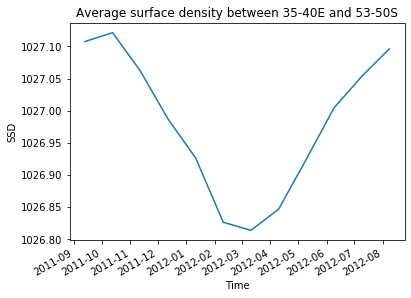

In [40]:
SSD_12times_small.mean(['i','j']).plot()
plt.title('Average surface density between 35-40E and 53-50S')
plt.savefig('surface_density_time_series.png')

In [ ]:
SSH_ps_x = xrft.power_spectrum(SSH_sel.isel(time=slice(0,180*24,10*24)),
                             dim=['i'],
                             window=True, 
                             detrend='constant').compute()

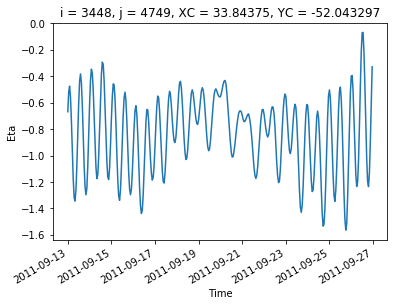

In [15]:
# Plot a short time series surface map
SSH_sel.isel(i=280, j=250).isel(time=slice(0,14*24)).plot()

In [9]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)
#grid

In [13]:
zeta = (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend')
        +grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz

In [14]:
zeta = grid.interp(grid.interp(zeta, 'Y', boundary='extend'), 
                   'X', boundary='extend')
# is there a right way to do this interpolation on a non-uniform grid?

In [15]:
zeta_sel = zeta.where(sel_area, drop=True)

In [16]:
zeta_sel = zeta_sel.assign_coords(XC=Xmean, YC=Ymean)

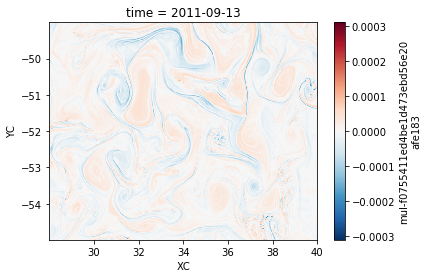

In [31]:
zeta_sel.isel(time=0).plot(x='XC', y='YC', cmap='RdBu_r')

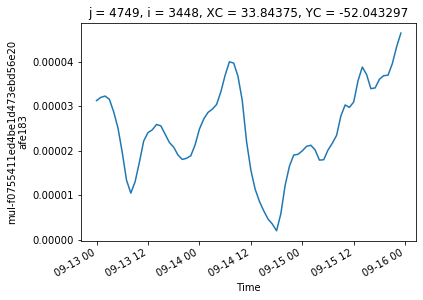

In [33]:
zeta_sel.isel(i=280, j=250).isel(time=slice(0,3*24)).plot()

### Power Spectra
- Velocity
- SSH

In [13]:
# Wavenumber spectra

SSH_ps_x = xrft.power_spectrum(SSH_sel.isel(time=slice(0,180*24,10*24)),
                             dim=['i'],
                             window=True, 
                             detrend='constant').compute()

SSH_ps_y = xrft.power_spectrum(SSH_sel.isel(time=slice(0,180*24,10*24)),
                             dim=['j'],
                             window=True, 
                             detrend='constant').compute()

In [14]:
# since the dimensions are just grid point indices
dx=1.3

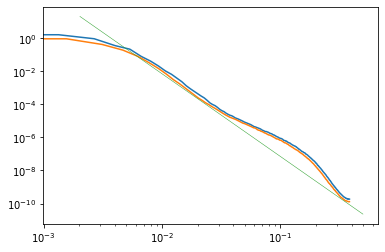

In [17]:
plt.plot(SSH_ps_x.freq_i/dx, SSH_ps_x.mean(['time','j']))
plt.plot(SSH_ps_y.freq_j/dx, SSH_ps_y.mean(['time','i']))
plt.plot(SSH_ps_y.freq_j, 0.7e-12*SSH_ps_y.freq_j**-5, linewidth=0.5)

plt.xscale('log')
plt.yscale('log')

### freq spectra

Follow the algorithm from https://gist.github.com/rabernat/fd2522f1937a43f49ac0423d35915648

In [13]:
subset_factor = 10


In [14]:
SSH_sel_subset = (SSH_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':1000}))

In [14]:
V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':1000}))

In [15]:
SSH_sel_subset

<xarray.DataArray 'Eta' (time: 1440, point: 2900)>
dask.array<rechunk-merge, shape=(1440, 2900), dtype=float32, chunksize=(480, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-11T23:00:00
    XC       (point) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    YC       (point) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
  * point    (point) MultiIndex
  - i        (point) int64 3168 3168 3168 3168 3168 ... 3738 3738 3738 3738 3738
  - j        (point) int64 4499 4509 4519 4529 4539 ... 4949 4959 4969 4979 4989

In [16]:
SSH_ps_t = xrft.power_spectrum(SSH_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [15]:
V_ps_t = xrft.power_spectrum(V_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [17]:
SSH_ps_t

<xarray.DataArray 'rechunk-merge-4af3a01b62631c2825cae368ac85852e' (time_segment: 3, freq_time: 480, point: 2900)>
dask.array<truediv, shape=(3, 480, 2900), dtype=float64, chunksize=(1, 480, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * point              (point) object (3168, 4499) (3168, 4509) ... (3738, 4989)
    freq_time_spacing  float64 5.787e-07

In [18]:
SSH_ps_t_av = SSH_ps_t.mean(dim=['time_segment', 'point'])

In [16]:
V_ps_t_av = V_ps_t.mean(dim=['time_segment', 'point'])

In [19]:
%time SSH_ps_t_av_p = SSH_ps_t_av.persist(retries=10)

CPU times: user 2.17 s, sys: 228 ms, total: 2.4 s
Wall time: 2.37 s


In [17]:
%time V_ps_t_av_p = V_ps_t_av.persist(retries=10)

CPU times: user 6.21 s, sys: 528 ms, total: 6.74 s
Wall time: 6.65 s


In [20]:
SSH_ps_t_av_p

<xarray.DataArray 'rechunk-merge-4af3a01b62631c2825cae368ac85852e' (freq_time: 480)>
dask.array<mean_agg-aggregate, shape=(480,), dtype=float64, chunksize=(480,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
    freq_time_spacing  float64 5.787e-07

In [23]:
SSH_ps_t_av_p.load()

<xarray.DataArray 'rechunk-merge-4af3a01b62631c2825cae368ac85852e' (freq_time: 480)>
array([5.11895041e-05, 4.90937830e-05, 5.18630723e-05, 5.53637294e-05,
       5.85559765e-05, 6.94685199e-05, 9.15206530e-05, 1.07906225e-04,
       1.95417356e-04, 1.73089450e-04, 1.28039528e-04, 1.88050790e-04,
       3.78117905e-04, 5.98132656e-04, 5.05213886e-04, 6.69596794e-04,
       7.22663449e-04, 5.73636781e-04, 3.40561988e-04, 4.17597623e-04,
       6.76436388e-04, 5.64484307e-04, 3.10981913e-04, 4.00696329e-04,
       3.56959770e-04, 7.49223380e-04, 1.04950510e-03, 9.54698555e-04,
       7.16197097e-04, 5.84478340e-04, 6.09695264e-04, 4.98236198e-04,
       4.79142872e-04, 5.82751780e-04, 8.25597570e-04, 5.67568805e-04,
       4.52744278e-04, 4.02823875e-04, 4.58959838e-04, 4.49147519e-04,
       4.16472831e-04, 4.83612650e-04, 5.52900119e-04, 6.70416648e-04,
       5.95096278e-04, 6.01037932e-04, 6.11235226e-04, 4.84020501e-04,
       3.93696013e-04, 5.52604098e-04, 6.53118227e-04, 8.96937342e-04,
       1.47554493e-03, 1.48171454e-03, 7.79570990e-04, 7.43484639e-04,
       1.32419845e-03, 9.88526780e-04, 6.53676118e-04, 1.05710679e-03,
       7.60080975e-04, 7.39524430e-04, 5.55401326e-04, 1.70506636e-03,
       4.81572922e-03, 5.86615236e-03, 2.83886253e-03, 3.02443969e-03,
       2.87118195e-03, 1.04897709e-03, 6.90670114e-04, 9.23365028e-04,
       5.37311775e-04, 6.07403666e-04, 3.48861179e-04, 2.68525056e-04,
       2.77593798e-04, 2.21776004e-04, 2.20099421e-04, 2.32518901e-04,
       2.46909609e-04, 2.71749193e-04, 3.10353727e-04, 3.66198729e-04,
       4.41794706e-04, 4.24154751e-04, 5.28861737e-04, 7.02532386e-04,
       1.41787326e-03, 1.24661002e-03, 1.39552347e-03, 1.29732225e-03,
       3.58033577e-03, 6.08773732e-03, 3.17168413e-03, 3.82627129e-03,
       4.50786371e-03, 1.54237844e-03, 9.75706728e-04, 1.36818370e-03,
       2.98220367e-03, 2.52062545e-03, 1.29360802e-03, 7.03928650e-04,
       7.54602036e-04, 9.61639608e-04, 1.20150522e-03, 1.11590387e-03,
       8.76388706e-04, 9.58112534e-04, 1.09943837e-03, 9.70060531e-04,
       1.04091238e-03, 1.15811693e-03, 1.01656960e-03, 1.06998208e-03,
       1.13173333e-03, 1.39195623e-03, 1.79541605e-03, 1.99075768e-03,
       2.51281991e-03, 4.51361025e-03, 8.70495805e-03, 6.42254970e-03,
       6.60602264e-03, 3.60258725e-03, 2.15902235e-03, 2.47719231e-03,
       2.12700852e-03, 2.11912523e-03, 2.36845554e-03, 1.80143359e-03,
       1.33146482e-03, 1.84072559e-03, 1.53803357e-03, 2.04795154e-03,
       1.69235430e-03, 1.82082609e-03, 2.66440248e-03, 1.96204052e-03,
       4.72212634e-03, 3.88893654e-03, 5.33909264e-03, 8.60403870e-03,
       8.76451409e-03, 1.10923011e-02, 9.20207296e-03, 1.79075174e-02,
       1.07545560e-02, 7.13553356e-03, 8.12277590e-03, 5.21563215e-03,
       4.00904816e-03, 6.45495132e-03, 8.71497996e-03, 9.18866616e-03,
       6.60002130e-03, 3.61172921e-03, 4.08950714e-03, 5.42220462e-03,
       8.23254802e-03, 1.68327135e-02, 1.21848387e-01, 2.31239057e-01,
       5.91132025e-02, 1.08383570e-02, 8.63110116e-03, 9.56221493e-03,
       6.32677284e-03, 8.78454523e-03, 1.05226498e-02, 1.06419802e-02,
       1.90852595e-02, 2.90671490e-02, 2.04187621e-02, 2.04988563e-02,
       1.81641062e-02, 1.15987920e-02, 5.92162155e-03, 9.54768817e-03,
       1.57359141e-02, 1.18924471e-02, 1.25001339e-02, 1.13753452e-02,
       1.04260558e-02, 1.33093148e-02, 1.27014786e-02, 1.18023091e-02,
       1.11068526e-02, 1.03669032e-02, 1.35451305e-02, 1.67336880e-02,
       1.38772477e-02, 1.15275002e-02, 1.19025827e-02, 1.91119746e-02,
       2.73476370e-02, 4.96207056e-02, 1.22285466e-01, 1.07306390e+02,
       4.58945870e+02, 1.14462437e+03, 8.02677399e+02, 2.98013030e+01,
       1.17890580e+00, 8.44868710e-02, 6.24932908e-02, 4.30157136e-02,
       6.28569207e-02, 8.40737125e-02, 7.44787906e-02, 9.25369223e-02,
       1.18541609e-01, 1.54175693e-01, 2.34052394e-01, 2.55151533e-01,
       1.93452083e-01, 2.51237420e-01, 7.51946880e-01, 3.31941350e+01,
       1.1

In [18]:
V_ps_t_av_p.load()

<xarray.DataArray 'rechunk-merge-475b3231aa5a524232a985e04f85cdc2' (freq_time: 480)>
array([8.06295145e-04, 8.00831380e-04, 7.91751286e-04, 7.91917067e-04,
       7.88084542e-04, 7.80678750e-04, 7.54821295e-04, 7.51774710e-04,
       7.58545044e-04, 7.42295358e-04, 7.27972334e-04, 7.25516751e-04,
       7.42986142e-04, 8.13897365e-04, 8.19374412e-04, 8.19066633e-04,
       8.02233035e-04, 7.72223753e-04, 7.22012488e-04, 7.12873999e-04,
       7.70558285e-04, 7.84301101e-04, 7.82237564e-04, 7.76051690e-04,
       8.09114660e-04, 8.35159032e-04, 8.38517877e-04, 8.95547516e-04,
       9.63314493e-04, 1.00765134e-03, 1.08234354e-03, 1.15385787e-03,
       1.16701753e-03, 1.21784929e-03, 1.26109611e-03, 1.35088917e-03,
       1.38908488e-03, 1.47563141e-03, 1.63588728e-03, 1.70860894e-03,
       1.81949098e-03, 1.87831747e-03, 1.91978752e-03, 1.90044413e-03,
       1.84549632e-03, 1.78914327e-03, 1.77195891e-03, 1.77843944e-03,
       1.81080142e-03, 1.84859341e-03, 1.77392851e-03, 1.67173454e-03,
       1.69544903e-03, 1.68702439e-03, 1.69884640e-03, 1.70893362e-03,
       1.66365641e-03, 1.65418930e-03, 1.75912111e-03, 1.84444786e-03,
       1.86402605e-03, 1.82485333e-03, 1.89991222e-03, 2.11313208e-03,
       2.31367337e-03, 2.46541387e-03, 2.45983348e-03, 2.53993610e-03,
       2.60305053e-03, 2.74689793e-03, 2.87797639e-03, 2.94296210e-03,
       3.28849948e-03, 3.63761810e-03, 3.85921947e-03, 4.28599051e-03,
       4.52677893e-03, 4.59976386e-03, 4.83831398e-03, 5.19586008e-03,
       5.41165764e-03, 5.87430734e-03, 6.36735743e-03, 6.22444714e-03,
       6.20679460e-03, 6.45752805e-03, 6.21486391e-03, 6.20825799e-03,
       6.11443645e-03, 5.78027955e-03, 5.64659005e-03, 5.69995118e-03,
       5.52076637e-03, 5.70269217e-03, 5.85083470e-03, 5.76881923e-03,
       5.68774929e-03, 5.64049346e-03, 5.66105375e-03, 5.67680907e-03,
       6.17562557e-03, 6.47258838e-03, 6.62620170e-03, 7.10796495e-03,
       7.45078673e-03, 8.01573460e-03, 8.48118780e-03, 9.14846141e-03,
       9.85883930e-03, 1.05700049e-02, 1.18066949e-02, 1.28462689e-02,
       1.40502210e-02, 1.52819562e-02, 1.63213774e-02, 1.85522832e-02,
       2.00094240e-02, 2.22860029e-02, 2.56607946e-02, 2.79453949e-02,
       3.00834711e-02, 3.18830760e-02, 3.30897867e-02, 3.24658924e-02,
       3.08408352e-02, 2.90455846e-02, 2.78467812e-02, 2.72940338e-02,
       2.54220359e-02, 2.40994750e-02, 2.28046066e-02, 2.23631843e-02,
       2.19366121e-02, 2.11213247e-02, 2.07972907e-02, 2.07501990e-02,
       2.07059864e-02, 2.04579185e-02, 2.14503116e-02, 2.26424420e-02,
       2.28060278e-02, 2.31879997e-02, 2.46884011e-02, 2.77517403e-02,
       3.05164471e-02, 3.21630614e-02, 3.49906069e-02, 3.81610648e-02,
       3.82983415e-02, 4.03888829e-02, 4.56773136e-02, 5.07174654e-02,
       5.70757168e-02, 6.54827643e-02, 7.60872705e-02, 8.50153762e-02,
       9.85412758e-02, 1.16494223e-01, 1.38809701e-01, 1.68748272e-01,
       1.98128169e-01, 2.11974707e-01, 1.99176766e-01, 1.80423273e-01,
       1.62938096e-01, 1.44490906e-01, 1.26226502e-01, 1.18856648e-01,
       1.10609468e-01, 1.04254916e-01, 9.91987041e-02, 9.80541584e-02,
       9.63856539e-02, 1.06544937e-01, 1.02264407e-01, 1.05137832e-01,
       1.07790686e-01, 1.08049195e-01, 9.86606048e-02, 1.03164728e-01,
       1.19773443e-01, 1.21337605e-01, 1.30981921e-01, 1.37517059e-01,
       1.48209637e-01, 1.67415218e-01, 1.83660902e-01, 2.07144125e-01,
       2.33618081e-01, 2.64095956e-01, 3.01415531e-01, 3.64234184e-01,
       4.37246524e-01, 5.33462617e-01, 6.39721755e-01, 8.03710612e-01,
       1.05489507e+00, 1.48437631e+00, 2.32277788e+00, 4.21958709e+00,
       7.94609297e+00, 1.00434459e+01, 7.92845653e+00, 3.93685949e+00,
       2.72323087e+00, 2.40419019e+00, 2.52255895e+00, 3.51455054e+00,
       4.99505154e+00, 6.14657084e+00, 4.76662862e+00, 3.72902737e+00,
       3.07022295e+00, 3.00524593e+00, 2.71390056e+00, 2.62265423e+00,
       1.95394874e+00, 1.74078343e+00, 3.04950390e+00, 4.08276199e+00,
       4.8

In [28]:
f = 2*2*np.pi/24/3600*np.sin(-52*np.pi/180)

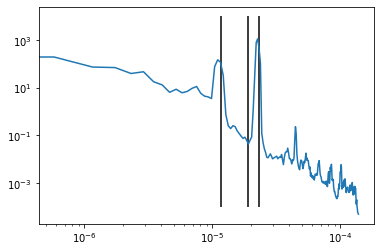

In [33]:
plt.plot(SSH_ps_t_av_p.freq_time, SSH_ps_t_av_p)
#plt.plot(-SSH_ps_t_av_p.freq_time, SSH_ps_t_av_p)
plt.vlines([1/86400, 1/43200, -f/2/np.pi], 1e-4, 1e4)
plt.xscale('log')
plt.yscale('log')

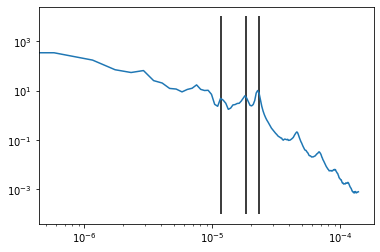

In [23]:
plt.plot(V_ps_t_av_p.freq_time, V_ps_t_av_p)
#plt.plot(-V_ps_t_av_p.freq_time, V_ps_t_av_p)
#plt.plot(-SSH_ps_t_av_p.freq_time, SSH_ps_t_av_p)
plt.vlines([1/86400, 1/43200, -f/2/np.pi], 1e-4, 1e4)
plt.xscale('log')
plt.yscale('log')

### Freq-wavenumber Spectra

In [46]:
V_sub_sel = (V_sel.isel(time=slice(0,120*24), i=slice(0,480), j=slice(0,494,10))
             .chunk({'time':480, 'i':120, 'j':10})
            )

In [47]:
V_sub_sel

<xarray.DataArray 'mul-be72df72ae2714b5fa2a46490d1bbfd5' (time: 2880, j: 50, i: 480)>
dask.array<rechunk-merge, shape=(2880, 50, 480), dtype=float32, chunksize=(480, 10, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-01-10T23:00:00
  * j        (j) int64 4499 4509 4519 4529 4539 ... 4949 4959 4969 4979 4989
  * i        (i) int64 3168 3169 3170 3171 3172 ... 3643 3644 3645 3646 3647

In [48]:
V_sub_sel_ps_xt =  xrft.power_spectrum(V_sub_sel, dim=['time','i'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [49]:
V_sub_sel_ps_xt_av =V_sub_sel_ps_xt.mean(dim=['time_segment', 'i_segment','j'])

In [50]:
V_sub_sel_ps_xt_av

<xarray.DataArray 'rechunk-merge-7d3fd87bc33448baa7f539f07bfb707d' (freq_time: 480, freq_i: 120)>
dask.array<mean_agg-aggregate, shape=(480, 120), dtype=float64, chunksize=(480, 120), chunktype=numpy.ndarray>
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * freq_i             (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.4833 0.4917
    freq_time_spacing  float64 5.787e-07
    freq_i_spacing     float64 0.008333

In [51]:
V_sub_sel_ps_xt_av_p = V_sub_sel_ps_xt_av.persist(retries=10)

In [52]:
V_sub_sel_ps_xt_av_p.load()

<xarray.DataArray 'rechunk-merge-7d3fd87bc33448baa7f539f07bfb707d' (freq_time: 480, freq_i: 120)>
array([[1.04107227e-08, 1.12789566e-08, 1.19001448e-08, ...,
        1.31518813e-08, 1.19001448e-08, 1.12789566e-08],
       [1.28444825e-08, 1.30603867e-08, 1.15295843e-08, ...,
        1.33477105e-08, 1.32307147e-08, 1.27799914e-08],
       [1.26221954e-08, 1.20858038e-08, 1.23950121e-08, ...,
        1.53392244e-08, 1.39019868e-08, 1.25169578e-08],
       ...,
       [1.21799457e-08, 1.21401537e-08, 1.13502246e-08, ...,
        1.37071862e-08, 1.36449215e-08, 1.26493934e-08],
       [1.26221954e-08, 1.25169578e-08, 1.39019868e-08, ...,
        1.33695028e-08, 1.23950121e-08, 1.20858038e-08],
       [1.28444825e-08, 1.27799914e-08, 1.32307147e-08, ...,
        1.14710503e-08, 1.15295843e-08, 1.30603867e-08]])
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * freq_i             (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.4833 0.4917
    freq_time_spacing  float64 5.787e-07
    freq_i_spacing     float64 0.008333

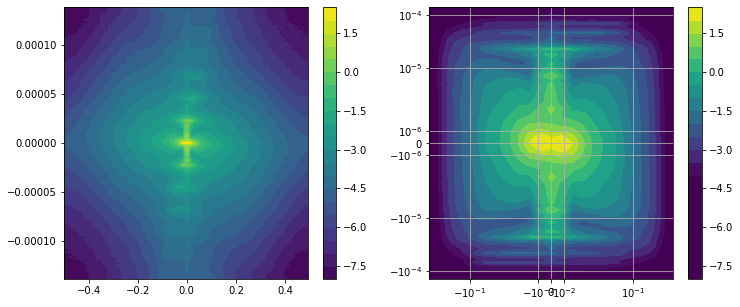

In [80]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
             np.log10(V_sub_sel_ps_xt_av_p), levels=20 )
#plt.xscale('symlog', linthreshx=1e-2)
#plt.yscale('symlog', linthreshy=1e-6)
plt.colorbar()

plt.subplot(122)
plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
             np.log10(V_sub_sel_ps_xt_av_p), levels=20 , vmin=-4)
plt.xscale('symlog', linthreshx=5e-2)
plt.yscale('symlog', linthreshy=5e-6)
plt.colorbar()
plt.grid()
#plt.xlim([-1 , 1])
#plt.ylim([-1e-4 , 1e-4])

### Cross Spectra
- Velocity*Temp
- Velocity*Salt

In [81]:
T_sel = ds.SST.where(sel_area, drop=True)

In [94]:
VT_cs_x = xrft.cross_spectrum(V_sel, T_sel, dim=['i'], 
                              window=True, detrend='constant')

In [83]:
VT_cs_x

<xarray.DataArray (time: 9030, j: 494, freq_i: 576)>
dask.array<truediv, shape=(9030, 494, 576), dtype=float64, chunksize=(1, 494, 576), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j               (j) int64 4499 4500 4501 4502 4503 ... 4989 4990 4991 4992
  * freq_i          (freq_i) float64 -0.5 -0.4983 -0.4965 ... 0.4965 0.4983
    freq_i_spacing  float64 0.001736

In [86]:
VT_cs_x_av = VT_cs_x.isel(time=slice(0,180*24,10*24), j=slice(0, None, 20)
                         ).mean(['j','time'])

In [88]:
VT_cs_x_av.load()

<xarray.DataArray (freq_i: 576)>
array([ 2.08741456e-07,  1.13261884e-07,  3.29792093e-11,  1.77251449e-08,
        6.53104047e-08,  5.26551148e-08,  8.19354157e-08,  6.79615172e-08,
        3.60189860e-08, -1.71148798e-08, -4.03137028e-08, -2.39507386e-08,
       -3.34472410e-09, -9.93005791e-08, -1.28494899e-07, -6.15795701e-08,
       -7.06337038e-08, -1.66304398e-07, -2.05789093e-07, -1.47763212e-07,
        1.09440008e-08, -1.18444811e-07, -1.55210564e-07, -4.90924000e-08,
       -5.51424414e-08, -2.30156527e-07, -2.36628474e-07, -1.53611233e-07,
       -1.32724652e-07, -3.28095821e-08,  7.73688318e-09, -6.44385635e-08,
       -6.44785764e-09,  8.74035847e-08,  1.40607252e-07,  1.58300038e-07,
       -8.31807181e-08, -2.13104044e-07, -8.77573328e-08, -1.46512558e-07,
       -1.63464055e-07,  7.44596824e-08, -7.17491132e-09, -3.84842969e-07,
       -4.01229687e-07, -1.95799264e-07,  2.83094402e-08,  2.22057600e-07,
        1.09837539e-07,  9.10897264e-08,  1.91913738e-08, -8.35971744e-08,
       -1.77367013e-07, -3.56596086e-08, -1.52469358e-07, -2.06130728e-07,
       -1.60409504e-07, -2.25319146e-07, -4.44805900e-07, -5.47772724e-07,
       -5.54598058e-07, -4.57741821e-07, -2.53600605e-07, -2.70625098e-07,
       -4.79964677e-07, -2.12262410e-07,  1.46338593e-07, -2.03329451e-08,
       -3.65098872e-07, -7.12702904e-08, -3.14256330e-07, -4.37030988e-07,
       -4.04077388e-07, -6.06398905e-07, -3.82496456e-07, -3.14422216e-07,
       -3.95744781e-07, -2.63142790e-07, -7.45059258e-07, -4.66779470e-07,
       -2.12851105e-07, -2.55924213e-07, -7.38339619e-07, -2.60162813e-07,
       -1.49245254e-06, -6.89158735e-07, -8.84920948e-08, -7.88032891e-07,
       -4.64507834e-07,  1.23944152e-06, -8.54752006e-08, -3.97394290e-07,
       -4.62450726e-07, -3.97979427e-07, -1.10515663e-06, -1.35708755e-06,
       -3.00030080e-07, -9.65400870e-07, -1.43061055e-06,  5.01643530e-07,
       -1.92643486e-06, -1.39721507e-06, -1.18606221e-06, -2.37006724e-06,
       -2.48813520e-06, -2.89962179e-06, -3.44373663e-06, -3.94149508e-06,
       -2.59626165e-06, -3.09984954e-06, -2.86513474e-06, -3.29105732e-06,
       -4.64811918e-06, -2.28090595e-06, -1.26755951e-06, -1.67556395e-06,
       -9.31950425e-07, -7.64626347e-07, -2.78344063e-06, -4.48441197e-06,
       -2.94449491e-06, -2.90152939e-06, -2.38272140e-06, -8.47941703e-07,
       -2.23893248e-06, -1.42550259e-06, -5.63045347e-06, -6.25855418e-06,
       -4.89220199e-06, -3.12271583e-06, -2.92447327e-06, -5.90745751e-06,
       -1.93665420e-06, -6.54512403e-06, -7.42265445e-06, -5.26109767e-06,
       -3.19516841e-06, -1.58973073e-06, -5.62647674e-06, -9.05034107e-06,
       -8.00111430e-06, -1.15061552e-05, -8.02549042e-06, -8.46006479e-06,
       -1.31228999e-05, -1.05435592e-05, -1.56171200e-05, -8.94096753e-06,
       -1.27246049e-05, -8.35084566e-06, -1.74440550e-05, -1.32923387e-05,
       -1.79591144e-05, -1.67068184e-05, -1.47187381e-05, -1.55091343e-05,
       -2.14741379e-05, -1.89529370e-05, -8.40388108e-06, -1.77265479e-05,
       -2.89099841e-05, -2.03980351e-05, -9.91859012e-06, -6.89038284e-06,
       -1.49915412e-05, -1.32054154e-05, -1.70459146e-05, -1.77393529e-05,
       -2.22290032e-05, -2.38798703e-05, -3.15294877e-05, -3.21730573e-05,
       -2.16902920e-05, -4.19188907e-05, -4.74845724e-05, -3.47629487e-05,
       -4.00481292e-05, -5.44412979e-05, -6.56339824e-05, -6.19106766e-05,
       -3.75172101e-05, -1.87218742e-05, -3.84276257e-06, -2.28268562e-05,
       -5.21643672e-05, -7.99286441e-05, -6.33309991e-05, -7.21203926e-05,
       -4.06829297e-05, -5.47238271e-05, -7.89294576e-05, -7.71470059e-05,
       -5.20447112e-05, -5.48989749e-05, -7.22297387e-05, -7.76944542e-05,
       -8.41680163e-05, -7.88424812e-05, -1.28664346e-04, -7.89386017e-05,
       -6.17846180e-05, -4.75263421e-05, -8.51185873e-05, -7.05708173e-05,
       -4.67180009e-05, -8.28357783e-05, -1.24902427e-04, -1.05391213e-04,
       -1.05163834e-04, -7.88227869e-05, -7.34711188e-05, -7.726714

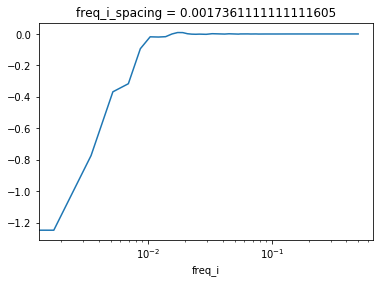

In [91]:
VT_cs_x_av.plot()
plt.xscale('log')

### Rotary Spectra
- Velocity

In [13]:
subset_factor = 15

In [17]:
U_sel_subset = (U_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':1000}))

V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':500}))

In [18]:
Z_sel_subset = U_sel_subset + 1j*V_sel_subset

In [19]:
Z_sel_subset

<xarray.DataArray (time: 1440, point: 1287)>
dask.array<add, shape=(1440, 1287), dtype=complex64, chunksize=(480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-11T23:00:00
  * point    (point) MultiIndex
  - i        (point) int64 3168 3168 3168 3168 3168 ... 3738 3738 3738 3738 3738
  - j        (point) int64 4499 4514 4529 4544 4559 ... 4919 4934 4949 4964 4979

In [20]:
Z_ps_t = xrft.power_spectrum(Z_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)
Z_ps_t

<xarray.DataArray 'rechunk-merge-4120e7bad57ca764c8a963eea30f93ff' (time_segment: 3, freq_time: 480, point: 1287)>
dask.array<truediv, shape=(3, 480, 1287), dtype=float64, chunksize=(1, 480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * point              (point) object (3168, 4499) (3168, 4514) ... (3738, 4979)
    freq_time_spacing  float64 5.787e-07

In [21]:
Z_ps_t_av = Z_ps_t.mean(dim=['time_segment', 'point'])

In [22]:
%time Z_ps_t_av_p = Z_ps_t_av.persist(retries=10)

CPU times: user 12.1 s, sys: 1.14 s, total: 13.2 s
Wall time: 13.1 s


In [23]:
Z_ps_t_av_p.load()

<xarray.DataArray 'rechunk-merge-4120e7bad57ca764c8a963eea30f93ff' (freq_time: 480)>
array([1.79027277e-03, 1.75150808e-03, 1.66965279e-03, 1.66457824e-03,
       1.60948786e-03, 1.58937005e-03, 1.49887274e-03, 1.43946840e-03,
       1.45805697e-03, 1.44038070e-03, 1.44629757e-03, 1.46019459e-03,
       1.39600425e-03, 1.53525084e-03, 1.52211897e-03, 1.53919151e-03,
       1.51453074e-03, 1.41476140e-03, 1.26567049e-03, 1.23117314e-03,
       1.36296284e-03, 1.45981836e-03, 1.40094673e-03, 1.33023526e-03,
       1.40878535e-03, 1.52465276e-03, 1.51755167e-03, 1.57096029e-03,
       1.65224605e-03, 1.67755150e-03, 1.76334209e-03, 1.87703751e-03,
       1.85160951e-03, 1.89865631e-03, 1.99659819e-03, 2.09408689e-03,
       2.22131108e-03, 2.31907682e-03, 2.52655291e-03, 2.64755283e-03,
       2.80944212e-03, 2.93238013e-03, 3.09479329e-03, 3.12560209e-03,
       3.03476338e-03, 2.97273207e-03, 2.85045310e-03, 2.75267587e-03,
       2.68945467e-03, 2.74517752e-03, 2.64873229e-03, 2.51006337e-03,
       2.49475210e-03, 2.46697740e-03, 2.42407872e-03, 2.41019320e-03,
       2.33471784e-03, 2.32434872e-03, 2.36191172e-03, 2.43812477e-03,
       2.49567594e-03, 2.54725958e-03, 2.59741986e-03, 2.66801248e-03,
       2.81710004e-03, 3.03803770e-03, 3.14849926e-03, 3.39495351e-03,
       3.56210865e-03, 3.61629946e-03, 3.84673339e-03, 4.04109906e-03,
       4.50523860e-03, 4.92481736e-03, 5.18621909e-03, 5.61163592e-03,
       5.72529111e-03, 6.05066446e-03, 6.54718050e-03, 6.82488774e-03,
       7.53585721e-03, 8.33870967e-03, 8.68224606e-03, 8.41452603e-03,
       8.14408280e-03, 8.11065559e-03, 8.13688438e-03, 8.22501371e-03,
       8.02954947e-03, 7.59720753e-03, 7.27452172e-03, 7.26010698e-03,
       7.13967628e-03, 7.62108643e-03, 7.35241222e-03, 7.58379370e-03,
       7.57126712e-03, 7.34176228e-03, 6.91658132e-03, 6.89570632e-03,
       7.64546937e-03, 7.93708607e-03, 8.15068751e-03, 8.20532044e-03,
       8.89719980e-03, 1.01141211e-02, 1.06875163e-02, 1.11079981e-02,
       1.18217527e-02, 1.24182034e-02, 1.34497633e-02, 1.52700671e-02,
       1.61781044e-02, 1.70962821e-02, 1.83941350e-02, 2.06568771e-02,
       2.33169032e-02, 2.61679433e-02, 2.85709417e-02, 3.07164212e-02,
       3.49885772e-02, 3.81789068e-02, 3.81080675e-02, 3.55851179e-02,
       3.42764310e-02, 3.46563497e-02, 3.24470908e-02, 3.03090177e-02,
       2.84617335e-02, 2.69092226e-02, 2.52108210e-02, 2.45322806e-02,
       2.32419559e-02, 2.28704909e-02, 2.23120330e-02, 2.13148897e-02,
       2.16640974e-02, 2.22016958e-02, 2.18657963e-02, 2.18638545e-02,
       2.32857078e-02, 2.34410891e-02, 2.50452030e-02, 2.76229769e-02,
       2.87109034e-02, 2.97967255e-02, 3.21940711e-02, 3.50478271e-02,
       3.68559770e-02, 3.91352945e-02, 4.17369716e-02, 4.59136687e-02,
       5.15356721e-02, 5.76635466e-02, 6.56489800e-02, 7.35453713e-02,
       8.09409192e-02, 9.19343893e-02, 1.07126099e-01, 1.26587803e-01,
       1.49161004e-01, 1.64946047e-01, 1.53889627e-01, 1.42122618e-01,
       1.25572667e-01, 1.09957122e-01, 9.44822494e-02, 8.91087902e-02,
       8.57618649e-02, 8.39393144e-02, 8.48073869e-02, 8.47839566e-02,
       8.40307246e-02, 9.78617180e-02, 1.03253878e-01, 1.09573354e-01,
       1.12054417e-01, 1.04935988e-01, 8.89713922e-02, 8.86644722e-02,
       1.11355123e-01, 1.27134478e-01, 1.31803382e-01, 1.27924852e-01,
       1.43367943e-01, 1.72320065e-01, 1.77137107e-01, 1.91811239e-01,
       2.16200467e-01, 2.11499920e-01, 2.18332436e-01, 2.47401923e-01,
       2.60868378e-01, 2.91628382e-01, 2.99219258e-01, 3.53340586e-01,
       4.21965792e-01, 5.10879575e-01, 6.42258599e-01, 8.72138040e-01,
       1.21681895e+00, 2.18949654e+00, 1.80992371e+00, 8.16268580e-01,
       7.45028658e-01, 7.34061668e-01, 7.11729565e-01, 8.22408901e-01,
       8.79216214e-01, 9.68652494e-01, 1.04133136e+00, 1.17713118e+00,
       1.26445556e+00, 1.34065860e+00, 1.50690409e+00, 1.72447710e+00,
       1.78219376e+00, 1.65901161e+00, 1.77707688e+00, 2.21981420e+00,
       3.1

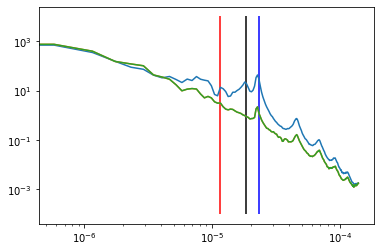

In [38]:
plt.plot(Z_ps_t_av.freq_time, Z_ps_t_av)
plt.plot(-Z_ps_t_av.freq_time, Z_ps_t_av)
plt.plot(-Z_ps_t_av.freq_time, Z_ps_t_av)
plt.vlines([1/86400, 1/43200, -f/2/np.pi], 1e-4, 1e4, 
           colors=['r','b','k'])
plt.xscale('log')
plt.yscale('log')

### Spectral Transfer Terms
- Tracer transfer terms

### Understand grids

In [35]:
YCcoarse = coords.YC.coarsen(i=20, j=20).mean()
XCcoarse = coords.XC.coarsen(i=20, j=20).mean()
RAcoarse = coords.rA.coarsen(i=20, j=20).mean()

In [11]:
dXCcoarse = coords.dxC.coarsen(i_g=20, j=20).mean()
dYCcoarse = coords.dyC.coarsen(i=20, j_g=20).mean()

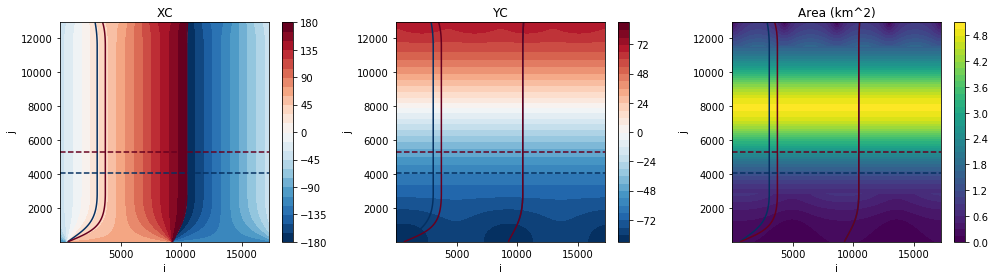

distributed.scheduler - INFO - Register tcp://10.32.22.2:39499
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.2:39499
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.22.3:34325
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.3:34325
distributed.core - INFO - Starting established connection


In [48]:
plt.figure(figsize=(14,4))

plt.subplot(131)
XCcoarse.plot.contourf(levels=36)
XCcoarse.plot.contour(levels=[26, 40])
YCcoarse.plot.contour(levels=[-60, -45])

plt.title('XC')

plt.subplot(132)
YCcoarse.plot.contourf(levels=36)
XCcoarse.plot.contour(levels=[26, 40])
YCcoarse.plot.contour(levels=[-60, -45])

plt.title('YC')

plt.subplot(133)
(RAcoarse/1e6).plot.contourf(levels=35)
XCcoarse.plot.contour(levels=[26, 40])
YCcoarse.plot.contour(levels=[-60, -45])

plt.title('Area (km^2)')

plt.tight_layout()

distributed.scheduler - INFO - Retire worker names (0,)
distributed.deploy.adaptive - INFO - Retiring workers [0]
distributed.scheduler - INFO - Remove worker tcp://10.32.95.8:42869
distributed.core - INFO - Removing comms to tcp://10.32.95.8:42869
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Register tcp://10.32.11.9:33423
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.11.9:33423
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Retire worker names (1,)
distributed.deploy.adaptive - INFO - Retiring workers [1]
distributed.scheduler - INFO - Remove worker tcp://10.32.11.9:33423
distributed.core - INFO - Removing comms to tcp://10.32.11.9:33423
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Register tcp://10.32.5.12:39141
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.5.12:39141
distributed.core - INFO - Starting established con

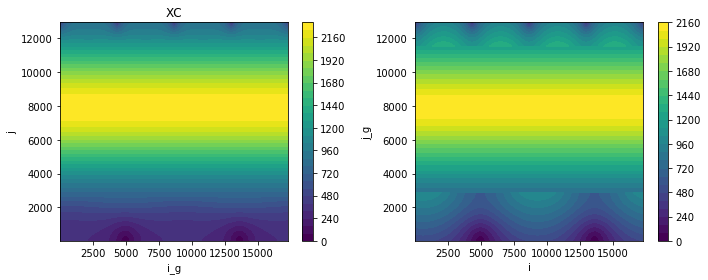

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(121)
dXCcoarse.plot.contourf(levels=36)
#dXCcoarse.plot.contour(levels=[26, 40])
#dYCcoarse.plot.contour(levels=[-60, -45])

plt.title('XC')

plt.subplot(122)
dYCcoarse.plot.contourf(levels=36)
#XCcoarse.plot.contour(levels=[26, 40])
#YCcoarse.plot.contour(levels=[-60, -45])

plt.tight_layout()

In [26]:
print(dask.config.get("distributed.logging"))
print(dask.config.get("distributed.scheduler.logging"))
print(dask.config.get("distributed.client.logging"))

{'bokeh': 'critical'}
error


KeyError: 'logging'

{'bokeh': 'critical'}

### Select Area

SOGOS area   
Lat ~ -55 -> -48  
Lon ~ 28 -> 40

In [60]:
sel_sogos = np.logical_and(np.logical_and(coords.XC>28, coords.XC<40 ), np.logical_and(coords.YC>-56, coords.YC<-48 ))

In [63]:
X = coords.XC.where(sel_sogos, drop=True)
Y = coords.YC.where(sel_sogos, drop=True)

In [83]:
Xmean = X.mean(['j'])
Ymean = Y.mean(['i'])
Xmax = X.max(['j'])
Xmin = X.min(['j'])
Ymax = Y.max(['i'])
Ymin = Y.min(['i'])

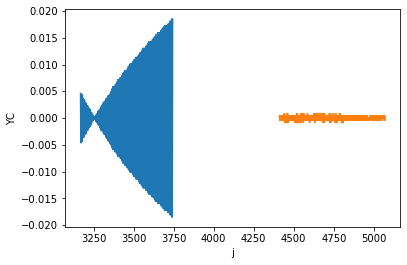

In [89]:
#Xmean.plot()
((Xmean-Xmin)*110).plot()
((Ymean-Ymin)*110).plot()

In [64]:
SST = ds.SST.where(sel_sogos, drop=True)

In [115]:
SSS = ds.SSS.where(sel_sogos, drop=True)

In [97]:
SSH = ds.Eta.where(sel_sogos, drop=True)

In [93]:
print(SST.time.isel(time=0).values)

2011-09-13T00:00:00.000000000


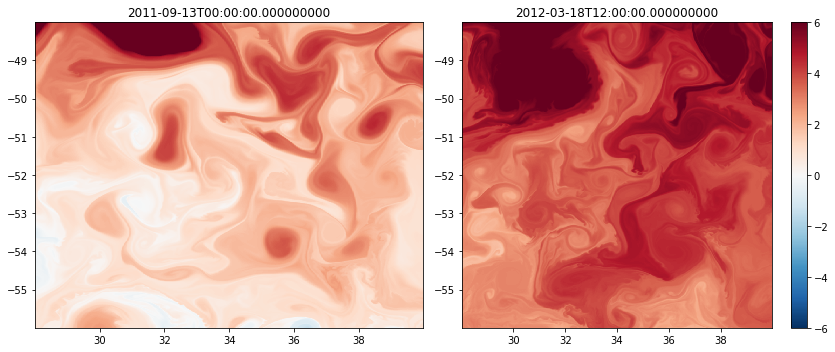

In [95]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pcolormesh(Xmean, Ymean, SST.isel(time=0), vmin=-6, vmax=6, cmap='RdBu_r')
plt.title(SST.time.isel(time=0).values)

plt.subplot(122)
plt.pcolormesh(Xmean, Ymean, SST.isel(time=4500), vmin=-6, vmax=6, cmap='RdBu_r')
plt.title(SST.time.isel(time=4500).values)
plt.colorbar()

plt.tight_layout()

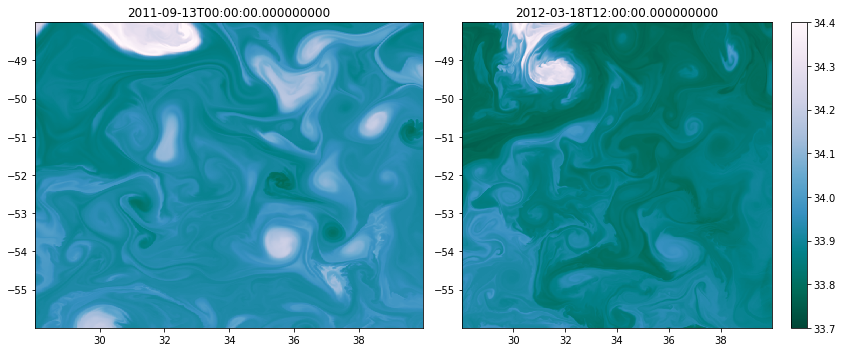

In [120]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pcolormesh(Xmean, Ymean, SSS.isel(time=0), vmin=33.7, vmax=34.4, cmap='PuBuGn_r')
plt.title(SSS.time.isel(time=0).values)

plt.subplot(122)
plt.pcolormesh(Xmean, Ymean, SSS.isel(time=4500), vmin=33.7, vmax=34.4, cmap='PuBuGn_r')
plt.title(SSS.time.isel(time=4500).values)
plt.colorbar()

plt.tight_layout()

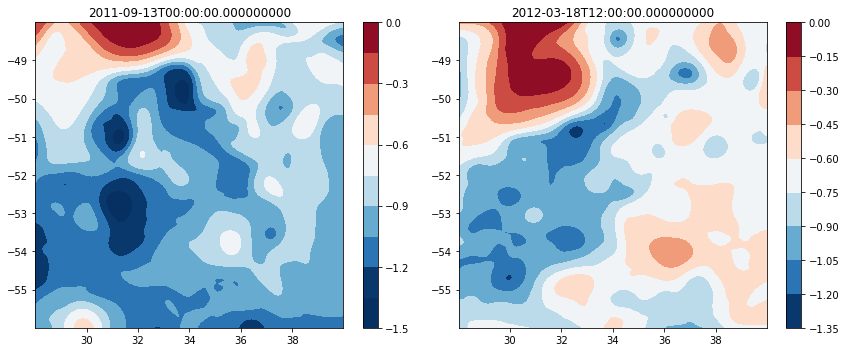

distributed.utils_perf - INFO - full garbage collection released 76.07 MB from 22185 reference cycles (threshold: 10.00 MB)


In [114]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.contourf(Xmean, Ymean, SSH.isel(time=slice(0,24)).resample(time='D').mean('time').isel(time=0), levels=11, vmin=-1.3, vmax=0, cmap='RdBu_r')
plt.colorbar()
plt.title(SST.time.isel(time=0).values)

plt.subplot(122)
plt.contourf(Xmean, Ymean,  SSH.isel(time=slice(4500,4524)).resample(time='D').mean('time').isel(time=0), levels=11, vmin=-1.3, vmax=0, cmap='RdBu_r')
plt.colorbar()
plt.title(SST.time.isel(time=4500).values)

plt.tight_layout()

distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


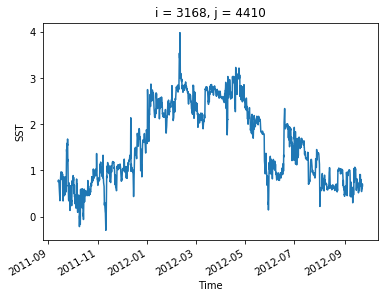

In [70]:
SST.isel(i=0, j=0).plot()

distributed.utils_perf - INFO - full garbage collection released 212.61 MB from 49249 reference cycles (threshold: 10.00 MB)


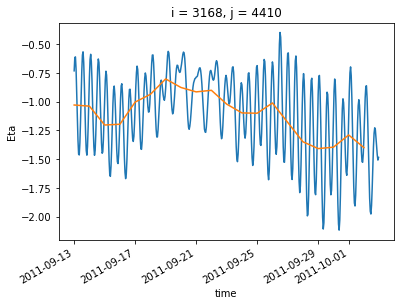

In [108]:
SSH.isel(i=0, j=0, time=slice(0,480)).plot()
SSH.isel(i=0, j=0, time=slice(0,480)).resample(time='D').mean().plot()